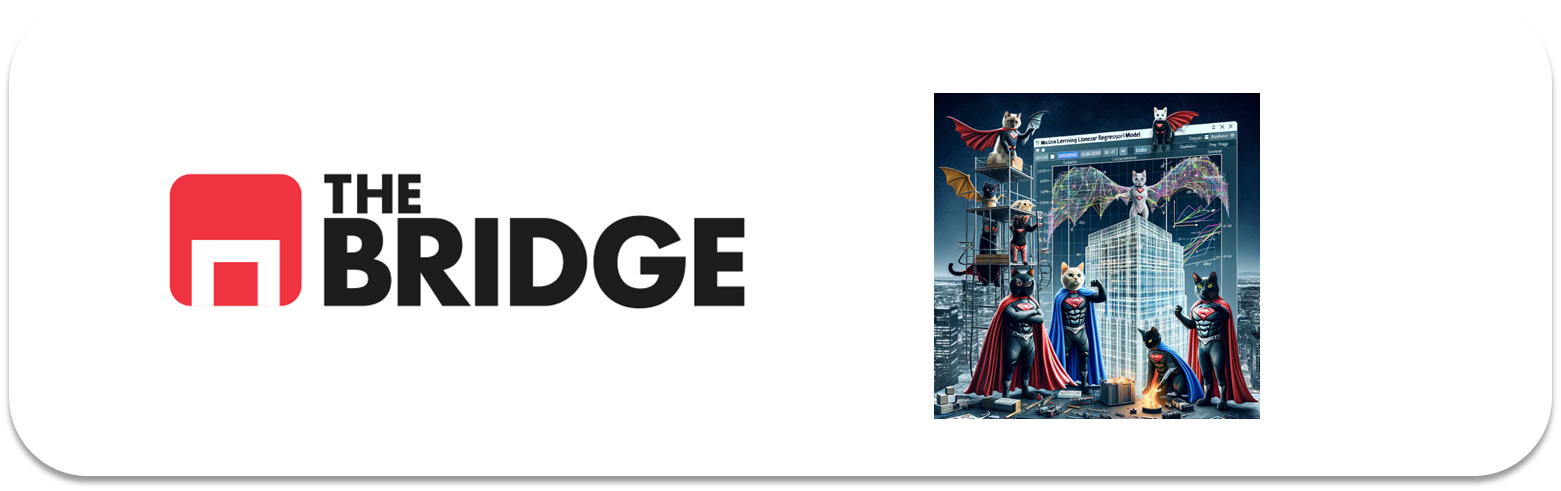

## Clasificación Binaria con Regresión Logística

### Entender el problema

Nos piden un modelo que prediga si los clientes van a pagar o impagar para poder hacer acciones preventivas en algún caso (clientes ya existentes) o comerciales (créditos preconcedidos). 

Parace muy claro, pero ¿qué significa impagar? ¿Es que mañana dejo de pagar una factura?¿Y si la repongo en menos de 30 días?¿Es tener una deuda a los seis meses sin pagar? Esto tenemos que aclararlo, no esperar a deducirlo del datatset (Aunque en estos ejemplos lo hagamos así). En nuestro caso nos contestan que es tener deudas pendientes de más de 2 años. Perfecto. Vamos con ello.

### Prepaaración Datos: Primer Vistazo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import bootcampviztools as booty
import sys
sys.path.append('/Users/aliciamarzoa/Will/the_bridge/personal_projects/stats_help')
import dstoolbox as tlbx

In [2]:
df = pd.read_csv('data/cs-training.csv')

df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Preparación Datos: Limpieza de datos

In [3]:
df.rename(columns = {'SeriousDlqin2yrs': 'target'}, inplace=True)

<Axes: xlabel='target', ylabel='count'>

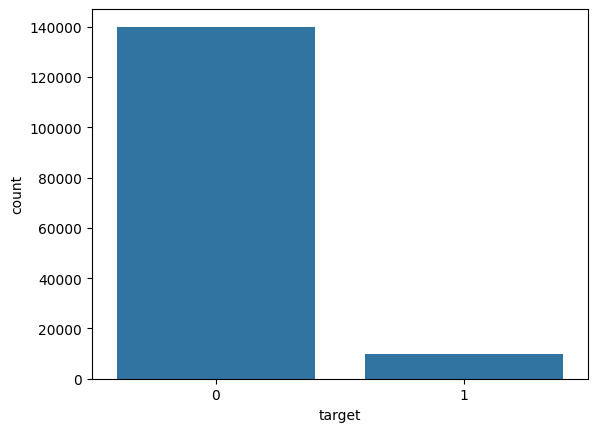

In [4]:
sns.countplot(data=df, x='target')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   target                                150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [6]:
# Nos cargamos columnas inutiles
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [7]:
# Nos cargamos nulls
df.dropna(inplace=True)

### Preparación datos: Dividimos el dataset

In [8]:
from sklearn.model_selection import train_test_split 

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

### MiniEDA: Matriz de correlación
Vamos a cargarnos algunas columnas que no estén muy relacionadas con el target (seria más aconsejable descartarlo haciendo un bivariante con test de hipótesis o usando pairplot, aunque hay que tener en cuenta que debe hacerse por partes porque pairplot es muy demandante y este dataset es grande en dato).

In [9]:
df_eda = X_train.copy()
df_eda["target"] = y_train.copy()

In [10]:
np.abs(df_eda.corr()['target']).sort_values(ascending=False)

target                                  1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.127577
NumberOfTimes90DaysLate                 0.115376
age                                     0.102266
NumberOfTime60-89DaysPastDueNotWorse    0.098259
NumberOfDependents                      0.046620
NumberOfOpenCreditLinesAndLoans         0.027646
MonthlyIncome                           0.018645
NumberRealEstateLoansOrLines            0.004433
DebtRatio                               0.003192
RevolvingUtilizationOfUnsecuredLines    0.002603
Name: target, dtype: float64

In [11]:
corr = np.abs(df_eda.corr()['target']).sort_values(ascending=False)

# Features con menos de 0.1 de correlación vs el target
bad_corr_feat = corr[corr < 0.05].index.values

# Filtramos las columnas buenas
df_eda.drop(columns=bad_corr_feat, inplace=True)

<Axes: >

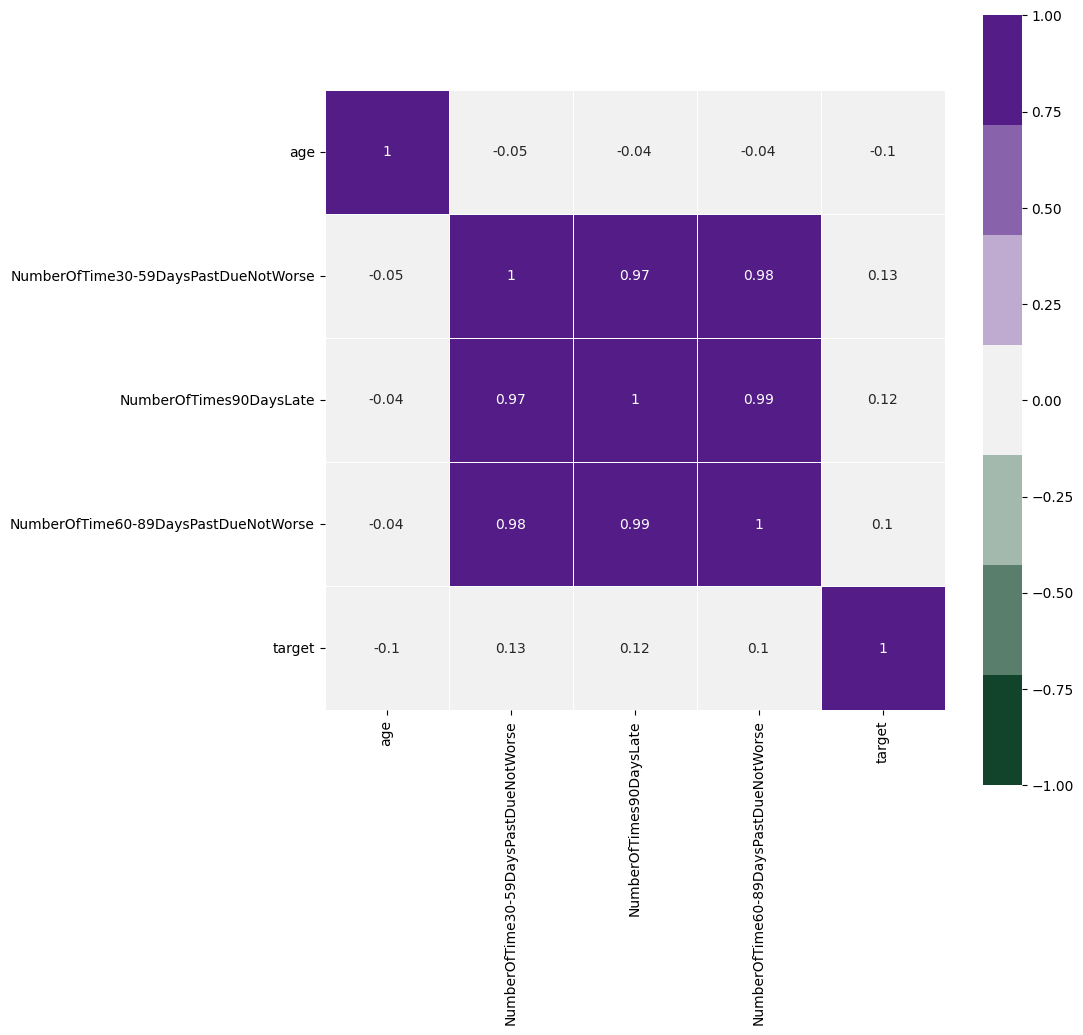

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df_eda.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5)

In [13]:
df_eda['target']

35298     0
110943    0
44650     1
97475     0
27331     0
         ..
137584    0
149506    0
129392    0
1052      1
19774     0
Name: target, Length: 96215, dtype: int64

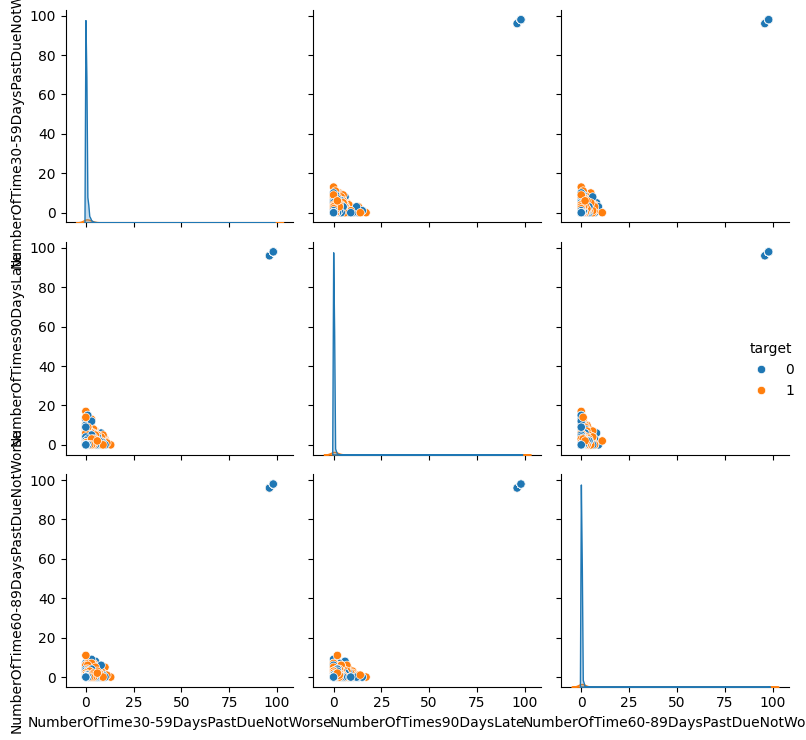

In [14]:
sns.pairplot(df_eda[[col for col in df_eda.columns if "NumberOf" in col or col == "target"]], hue = "target")
plt.tight_layout()

Te invito a usar nuestra librería de funciones gráficas para hacer un bivariante al estilo de las diagonales para las features con la mayor correlación.

In [15]:
df_eda.columns.to_list()

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'target']

In [16]:
df_eda['target'].value_counts()

0    89556
1     6659
Name: target, dtype: int64

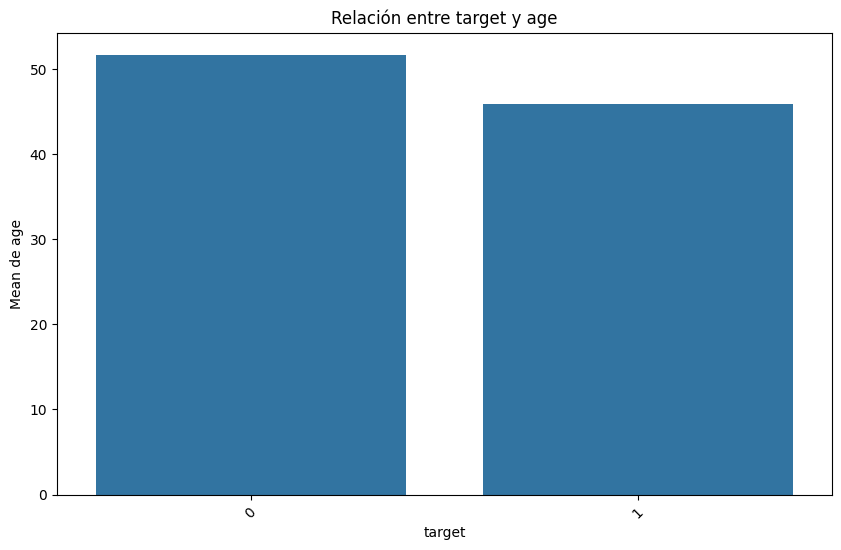

In [17]:
booty.plot_categorical_numerical_relationship(df_eda, 'target', 'age', show_values=False, measure='mean')

<Axes: xlabel='age', ylabel='Count'>

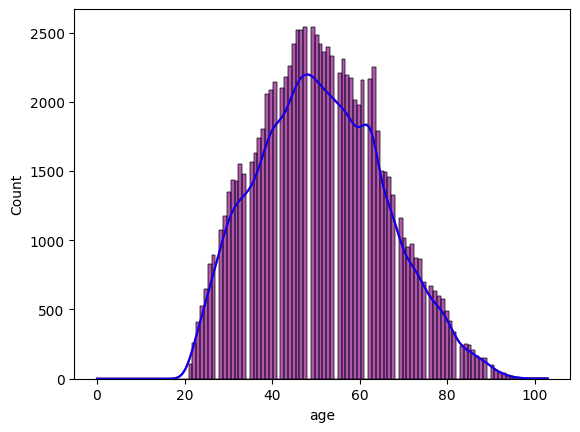

In [18]:
sns.histplot(x=df_eda['age'], data=df_eda[df_eda['target'] == 0], kde=True, color='red')
sns.histplot(x=df_eda['age'], data=df_eda[df_eda['target'] == 1], kde=True, color='blue', alpha=0.3)

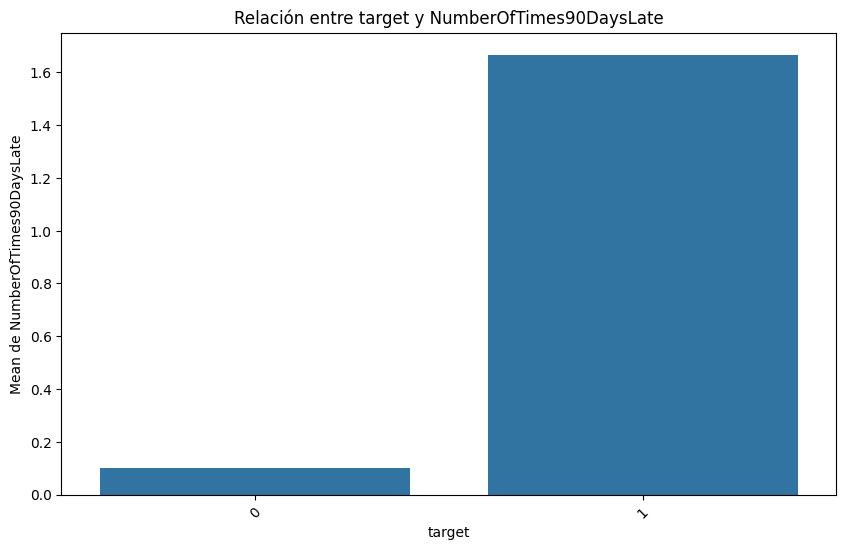

In [19]:
booty.plot_categorical_numerical_relationship(df_eda, 'target', 'NumberOfTimes90DaysLate', show_values=False, measure='mean')

<Axes: xlabel='NumberOfTimes90DaysLate', ylabel='Count'>

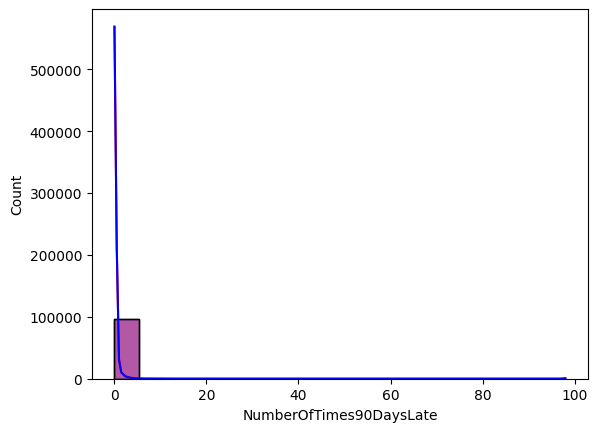

In [20]:
sns.histplot(x=df_eda['NumberOfTimes90DaysLate'], data=df_eda[df_eda['target'] == 0], kde=True, color='red')
sns.histplot(x=df_eda['NumberOfTimes90DaysLate'], data=df_eda[df_eda['target'] == 1], kde=True, color='blue', alpha=0.3)

In [21]:
df_eda['NumberOfTimes90DaysLate'].describe()

count    96215.000000
mean         0.210248
std          3.444867
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

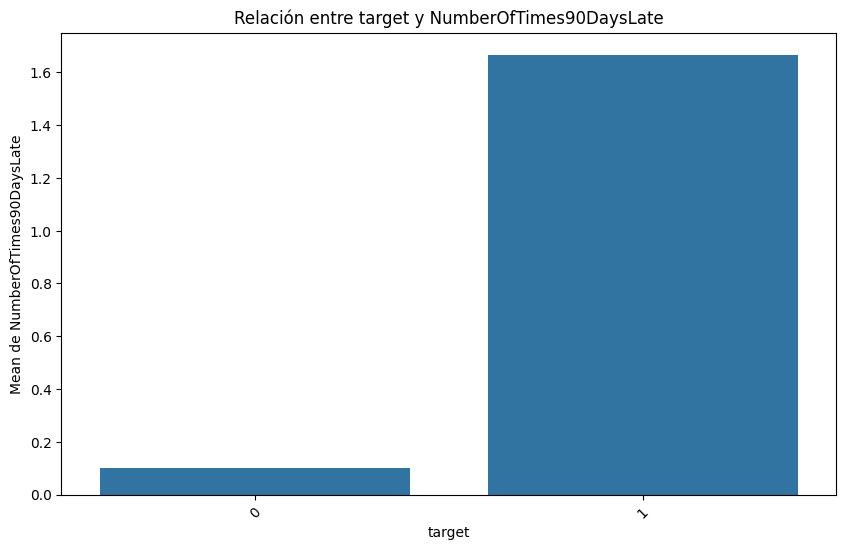

In [22]:
booty.plot_categorical_numerical_relationship(df_eda, 'target', 'NumberOfTimes90DaysLate', show_values=False, measure='mean')

<Axes: xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Count'>

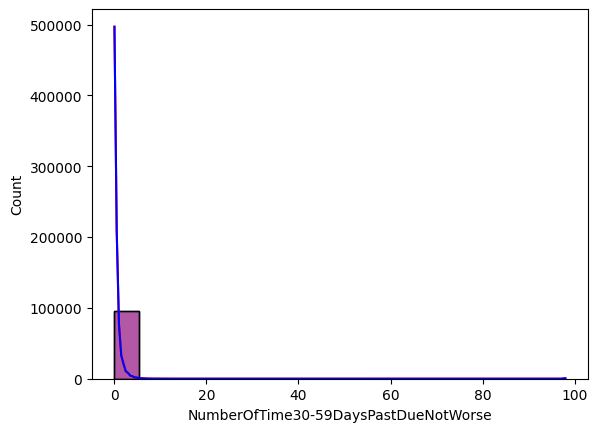

In [23]:
sns.histplot(x=df_eda['NumberOfTime30-59DaysPastDueNotWorse'], data=df_eda[df_eda['target'] == 0], kde=True, color='red')
sns.histplot(x=df_eda['NumberOfTime30-59DaysPastDueNotWorse'], data=df_eda[df_eda['target'] == 1], kde=True, color='blue', alpha=0.3)

In [24]:
df_eda['NumberOfTime30-59DaysPastDueNotWorse'].describe()

count    96215.000000
mean         0.380211
std          3.479168
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

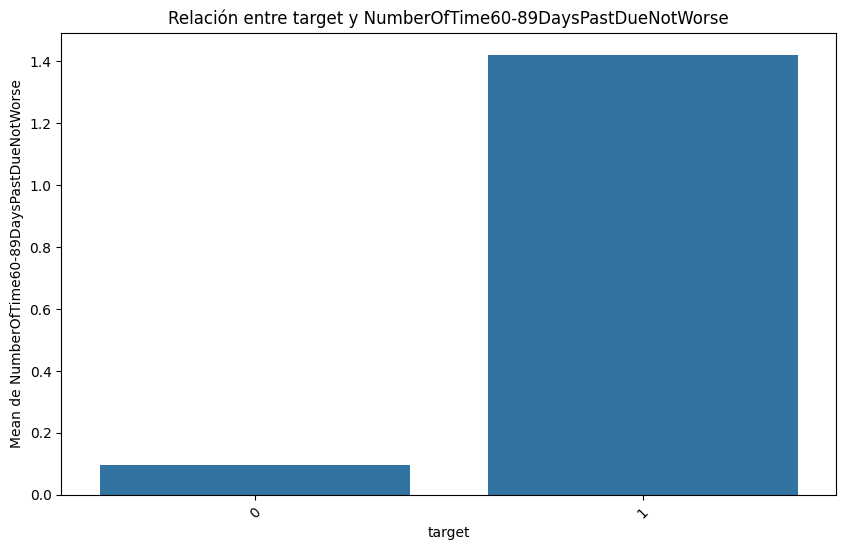

In [25]:
booty.plot_categorical_numerical_relationship(df_eda, 'target', 'NumberOfTime60-89DaysPastDueNotWorse', show_values=False, measure='mean')


<Axes: xlabel='NumberOfTime60-89DaysPastDueNotWorse', ylabel='Count'>

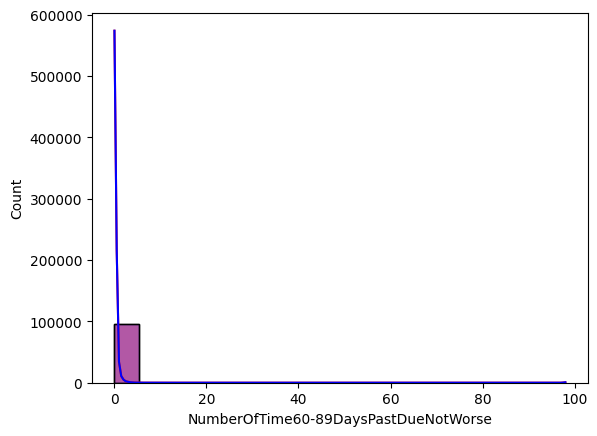

In [26]:
sns.histplot(x=df_eda['NumberOfTime60-89DaysPastDueNotWorse'], data=df_eda[df_eda['target'] == 0], kde=True, color='red')
sns.histplot(x=df_eda['NumberOfTime60-89DaysPastDueNotWorse'], data=df_eda[df_eda['target'] == 1], kde=True, color='blue', alpha=0.3)

In [27]:
df_eda['NumberOfTime60-89DaysPastDueNotWorse'].describe()

count    96215.000000
mean         0.186676
std          3.427351
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [28]:
df_eda['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()


0     91186
1      3849
2       730
3       222
98      113
4        66
5        22
6        14
7         6
96        4
8         1
9         1
11        1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [29]:
features_num = [col for col in df_eda.columns if "target" not in col]
X_train = X_train[features_num].copy()

### Preparación de Features

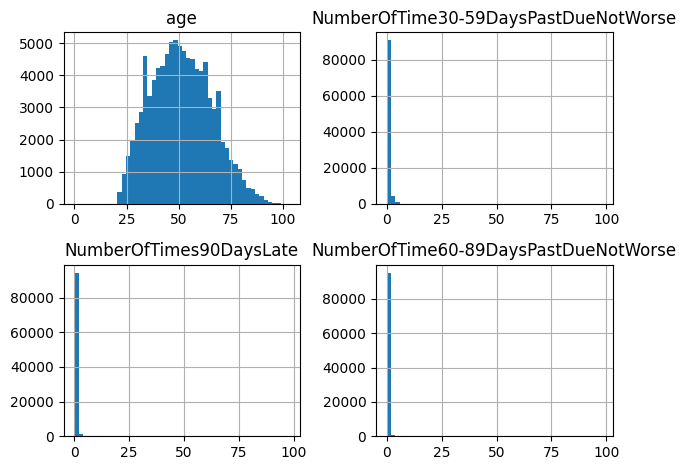

In [30]:
X_train.hist(bins=50)
plt.tight_layout()

In [31]:
X_train.describe()

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
count,96215.000000,96215.000000,96215.000000,96215.000000
mean,51.285174,0.380211,0.210248,0.186676
std,14.428079,3.479168,3.444867,3.427351
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,0.000000,0.000000
50%,51.000000,0.000000,0.000000,0.000000
75%,61.000000,0.000000,0.000000,0.000000
max,103.000000,98.000000,98.000000,98.000000


In [32]:
X_train[X_train["NumberOfTime30-59DaysPastDueNotWorse"] > 0]

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
44650,41,2,1,0
27331,39,1,0,0
85530,53,1,0,0
106214,45,3,0,0
106548,47,2,0,0
...,...,...,...,...
934,45,1,0,0
51349,30,3,0,0
55095,61,2,0,0
46514,78,1,0,0


Podríamos hacer categóricas de las "veces en días vencidos", pero lo vamos a dejar así por espacio, no son variables para escalar necesariamente.

### Modelo

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

Veremos los hiperparámetros (en este caso argumentos al constructor de la clase LogisticRegression) a medida que vayamos usando el modelo. Ahora tratemos "max_iter":

`max_iter` = numero de iteraciones del optimizador (recuerda que el gradiente descendente va probando combinaciones hasta que encuentra una que no mejora la función de minimización después de varios intentos), esta es otra forma de decirle el máximo número de combinaciones, de veces que se aplica el gradiennte descendente en caso de que no se llegue a la condición anterior (denominada tolerancia)



In [34]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-0.02789005  0.50545197  0.43902964 -0.90509617]]
[-1.46245404]
[0 1]


### Feature importance

In [35]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
NumberOfTime60-89DaysPastDueNotWorse,0.905096
NumberOfTime30-59DaysPastDueNotWorse,0.505452
NumberOfTimes90DaysLate,0.439030
age,0.027890


In [46]:
df

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


<BarContainer object of 4 artists>

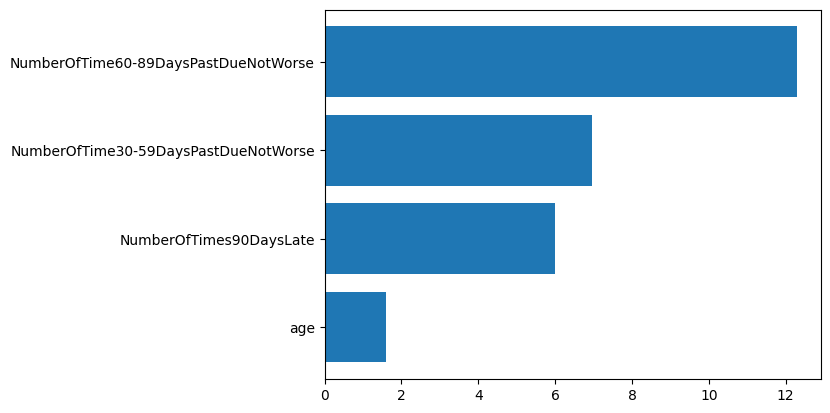

In [36]:
stdevs = []
for i in X_train.columns:
    stdev = df[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()

features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized)

***

## Accuracy

Antes de usar el X_test hay que hacerles las mismas transformaciones que le hayamos hecho al X_train

In [37]:
X_test = X_test[X_train.columns].copy()

In [38]:
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.932
Accuracy test: 0.929


¿Es buenos nuestro clasificador?

In [39]:
y_train.value_counts(True)

0    0.93079
1    0.06921
Name: target, dtype: float64

In [40]:
y_test.value_counts(True)

0    0.929409
1    0.070591
Name: target, dtype: float64

No, no lo es. Tendríamos que tratarlo de alguna forma mejor (Está muy desbalanceado) o ver otras métricas

### Confusion matrix

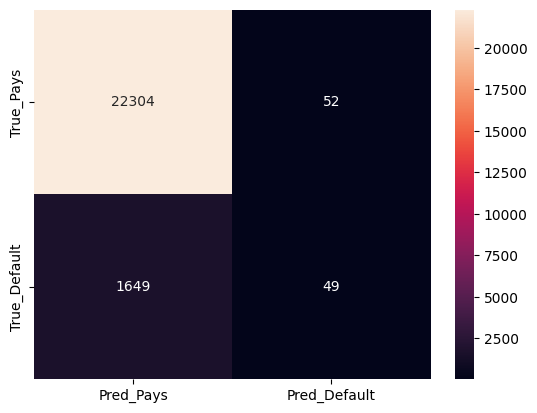

In [41]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

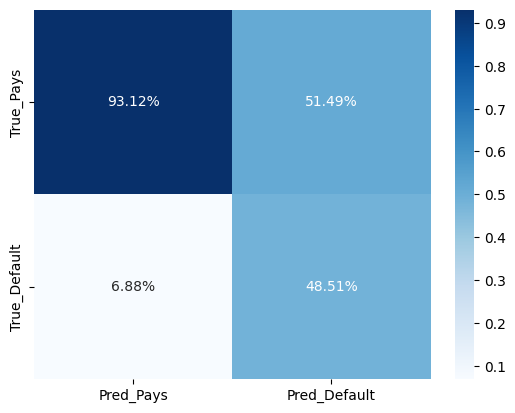

In [53]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

## Classification report

In [54]:
from sklearn.metrics import classification_report
from pprint import pprint

print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22356
           1       0.49      0.03      0.05      1698

    accuracy                           0.93     24054
   macro avg       0.71      0.51      0.51     24054
weighted avg       0.90      0.93      0.90     24054



In [45]:
y_test.value_counts(True)

0    0.929409
1    0.070591
Name: target, dtype: float64

- True Negative:
    - Truely predicted neagtive
    - Negative case (0) and the prediciton was correct
    - it was 0 and model predicted 0
- False Negative:
    - Falsely predicted negative
    - positive case (1) and the prediction was incorrect
    - it was 1 and model predicted 0
- True Positive:
    - Truely predicted positive
    - Positive case (1) and the prediction was correct
    - it was 1 and model predicted 1
- False Positive:
    - Falsely predicted positive
    - Negative case (0) and the prediction was incorrect
    - it was 0 and the model predicted 1

- Precision:
    - focus on one class
    - apples side of table
    - total correctly predicted cases / all predictions for that case
    - precision for class 1
        - correct prediction for class 1 / all predictions for class 1
    ---
    - for a given class, how many of the predictions made for a given class were correct.
    - how many of my predictions for positive were actually positive
    - how many times does model make a prediction for a class and it is correct
    - e.g. predicted class 0 30 times, 15 were actually 0, 50% precision
    - e.g. predicted class 1 40 times, 30 were actually 1, 75% precision

    - true pos / true pos + false pos
    - correct prediction of positives / all predictions of positive class
    - for class 1 (didnt pay):
        - model predicted 50% of these cases correctly
        - e.g. correctly identified only 50% of non-payer cases
        
- Recall:
    - focus on both classes
    - all apples
    - how many did you predict correctly / how many of them were there.
    - for a given class, how many did you put in the correct category

## ROC Curve

AUROC: 0.69


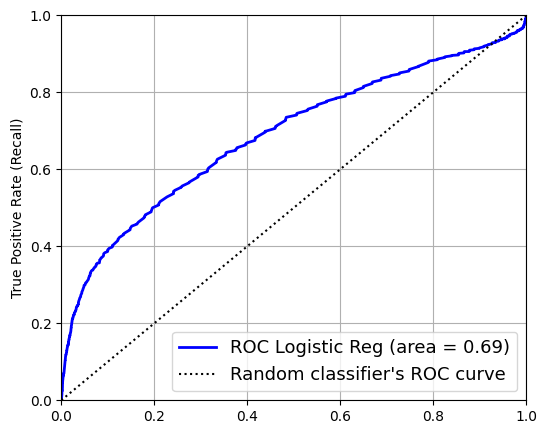

In [55]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)